In [98]:
NOTEBOOK_NAME = "e020_add_feat_by_yuki"

In [99]:
import os
import warnings
from pathlib import Path

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore")

In [100]:
ROOT_DIR = Path("../")
DATA_DIR = ROOT_DIR / Path("data")

In [101]:
train = pd.read_csv(DATA_DIR / Path("train.csv"))
test = pd.read_csv(DATA_DIR / Path("test.csv"))
era = pd.read_csv(DATA_DIR / Path("era_improve.csv"))

display(train.head(5))
display(test.head(5))
display(era.head(5))

,名称,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度,is_kokuhou
0,泉布観,NaN,近代／文化施設,NaN,明治,大阪府,大阪府大阪市北区天満橋一丁目1番1号,NaN,大阪市,NaN,34.69811,135.5214,0
1,絹本著色准胝仏母像,NaN,絵画,日本,鎌倉,京都府（京都府）,NaN,NaN,広隆寺,NaN,NaN,NaN,0
2,石上神宮拝殿,NaN,近世以前／寺院,NaN,鎌倉前期,奈良県,奈良県天理市布留町,NaN,石上神宮,NaN,34.59780,135.8520,1
3,剣〈銘真守（備前）／〉,NaN,工芸品,日本,鎌倉,和歌山県（和歌山県）,NaN,NaN,宗教法人金剛峯寺,財団法人高野山文化財保存会,NaN,NaN,0
4,旧新町紡績所,工場本館,近代／産業・交通・土木,NaN,明治,群馬県,群馬県高崎市新町二三三〇番地,NaN,クラシエフーズ株式会社,NaN,36.27766,139.1003,0


,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度
0,NaN,工芸品,日本,江戸,京都府（京都府）,NaN,NaN,相国寺,NaN,NaN,NaN
1,NaN,絵画,日本,平安,和歌山県（和歌山県）,NaN,NaN,西禅院,財団法人高野山文化財保存会,NaN,NaN
2,NaN,絵画,日本,平安,東京都（東京都）,東京都世田谷区上野毛3-9-25,公益財団法人五島美術館,東急株式会社,NaN,35.612290,139.635500
3,NaN,近世以前／神社,NaN,江戸前期,和歌山県,和歌山県有田郡広川町大字上中野,NaN,廣八幡宮,NaN,34.017835,135.175324
4,NaN,彫刻,日本,平安,山形県（山形県）,NaN,NaN,吉祥院,NaN,NaN,NaN


,時代,開始,終了
0,鎌倉,1185,1333
1,平安,794,1185
2,明治,1868,1912
3,桃山,1573,1603
4,江戸中期,1603,1868


In [102]:
train = train.merge(era, how="left", on="時代")
test = test.merge(era, how="left", on="時代")

train["時代_期間"] = train["終了"] - train["開始"]
test["時代_期間"] = test["終了"] - test["開始"]

# 特徴量エンジニアリング

In [103]:
import re


def get_prefecture(text: str) -> str | None:
    all_prefectures = (
        "北海道|青森県|岩手県|宮城県|秋田県|山形県|福島県|"
        + "茨城県|栃木県|群馬県|埼玉県|千葉県|東京都|神奈川県|"
        + "新潟県|富山県|石川県|福井県|山梨県|長野県|岐阜県|静岡県|愛知県|"
        + "三重県|滋賀県|京都府|大阪府|兵庫県|奈良県|和歌山県|"
        + "鳥取県|島根県|岡山県|広島県|山口県|"
        + "徳島県|香川県|愛媛県|高知県|"
        + "福岡県|佐賀県|長崎県|熊本県|大分県|宮崎県|鹿児島県|沖縄県"
    )
    if match := re.search(all_prefectures, text):
        return match.group(0)
    else:
        return None


# 都道府県を抽出
train["都道府県"] = train["都道府県 ※美工品は「所有者住所（所在都道府県）」"].map(
    get_prefecture, na_action="ignore"
)
test["都道府県"] = test["都道府県 ※美工品は「所有者住所（所在都道府県）」"].map(get_prefecture, na_action="ignore")

In [104]:
# 種別2より建造物か美工品かを分類する特徴を追加
kenzoubutu_feat = [
    "近世以前／神社",
    "近世以前／神社",
    "近世以前／寺院",
    "近世以前／城郭",
    "近世以前／住宅",
    "近世以前／民家",
    "近世以前／その他",
    "近代／宗教",
    "近代／学校",
    "近代／官公庁舎",
    "近代／産業・交通・土木",
    "近代／住居",
    "近代／文化施設",
    "近代／商業・業務",
    "近代／その他",
]

bikouhin_feat = ["宝", "絵画", "彫刻", "工芸品", "書跡・典籍", "古文書", "考古資料", "歴史資料"]


def classify_kenzoubutu_bikouhin(text: str | None) -> str | None:
    if text in kenzoubutu_feat:
        return "建造物"
    elif text in bikouhin_feat:
        return "美工品"
    return None


train["建造物_or_美工品"] = train["種別2"].map(classify_kenzoubutu_bikouhin, na_action="ignore")
test["建造物_or_美工品"] = test["種別2"].map(classify_kenzoubutu_bikouhin, na_action="ignore")

In [105]:
def classify_kenzoubutu_genre(text: str | None) -> str | None:
    if text == "近世以前／神社":
        return "神社"
    elif text == "近世以前／寺院":
        return "寺院"
    elif text == "近世以前／城郭":
        return "城郭"
    elif text == "近世以前／住宅":
        return "住宅"
    elif text == "近世以前／民家":
        return "民家"
    elif text == "近世以前／その他":
        return "その他"
    elif text == "近代／宗教":
        return "宗教"
    elif text == "近代／学校":
        return "学校"
    elif text == "近代／官公庁舎":
        return "官公庁舎"
    elif text == "近代／産業・交通・土木":
        return "産業・交通・土木"
    elif text == "近代／住居":
        return "住居"
    elif text == "近代／文化施設":
        return "文化施設"
    elif text == "近代／商業・業務":
        return "商業・業務"
    elif text == "近代／その他":
        return "その他"  # ここはその他で被っている
    return None


train["建造物_種類"] = train["種別2"].map(classify_kenzoubutu_genre, na_action="ignore")
test["建造物_種類"] = test["種別2"].map(classify_kenzoubutu_genre, na_action="ignore")

In [106]:
# 時代を取得する
import re


def get_era(text: str) -> str | None:
    all_era = [
        "鎌倉",
        "元",
        "古墳",
        "江戸",
        "高麗",
        "室町",
        "昭和",
        "大正",
        "唐",
        "桃山",
        "奈良",
        "縄文",
        "縄文",
        "南宋",
        "南北朝",
        "飛鳥",
        "平安",
        "北宋",
        "明治",
        "弥生",
        "明",
    ]
    for era in all_era:
        if era in text:
            return era
    return None


train["時代_抽出"] = train["時代"].map(get_era, na_action="ignore")
test["時代_抽出"] = test["時代"].map(get_era, na_action="ignore")

In [107]:
def get_shoyusya_genre(text: str) -> str | None:
    words = [
        "神宮",
        "八幡宮",
        "神社",
        "株式会社",
        "有限会社",
        "研究機構",
        "独立行政法人",
        "公益財団法人",
        "財団法人",
        "学校法人",
        "大学",
        "県",
        "市",
        "区",
        "国",
        "寺",
    ]
    for word in words:
        if word in text:
            return word
    return None


train["所有者名_genre"] = train["所有者名"].map(get_shoyusya_genre, na_action="ignore")
test["所有者名_genre"] = test["所有者名"].map(get_shoyusya_genre, na_action="ignore")

In [108]:
# 緯度と経度のブロックを追加する
def classify_coordinates_japan(lat: float, lon: float) -> str | None:
    if np.isnan(lat) or np.isnan(lon):
        return None

    lat_block = int((lat - 24) // (22 / 50))
    lon_block = int((lon - 123) // (30 / 50))

    return f"{lat_block}_{lon_block}"


train_outputs = []
for i, j in zip(train["緯度"], train["経度"]):
    train_outputs.append(classify_coordinates_japan(i, j))

test_outputs = []
for i, j in zip(test["緯度"], test["経度"]):
    test_outputs.append(classify_coordinates_japan(i, j))

train["緯度_経度_ブロック"] = train_outputs
test["緯度_経度_ブロック"] = test_outputs

In [109]:
from unicodedata import normalize


def get_prefecture_city(text: str | None) -> str | None:
    if text is None:
        return None
    text = normalize("NFKC", text)
    address_pattern = r"([一-龠]{1,3}[都道府県])([一-龠]{1,3}[市区町村])"

    if match := re.search(address_pattern, text):
        return match.group(1) + match.group(2)
    return None


train["所在地_pref_city"] = train["所在地"].map(get_prefecture_city, na_action="ignore")
test["所在地_pref_city"] = test["所在地"].map(get_prefecture_city, na_action="ignore")

In [110]:
def get_shozaiti_first(text: str | None) -> str | None:
    if text is None:
        return None
    text = normalize("NFKC", text)
    if " " in text:
        return text.split(" ")[0]
    return None


train["所在地_first"] = train["所在地"].map(get_shozaiti_first, na_action="ignore")
test["所在地_first"] = test["所在地"].map(get_shozaiti_first, na_action="ignore")

In [111]:
# 近傍の値の追加
import pickle

with open("../eda/neighbor_train_feat.pkl", "rb") as f:
    neighbor_train_feat = pickle.load(f)

with open("../eda/neighbor_test_feat.pkl", "rb") as f:
    neighbor_test_feat = pickle.load(f)

train["kokuhou_kinbou"] = neighbor_train_feat
test["kokuhou_kinbou"] = neighbor_test_feat

In [112]:
categorical_cols = [
    "棟名",
    "種別2",
    "国",
    "都道府県 ※美工品は「所有者住所（所在都道府県）」",
    "時代",
    "保管施設の名称",
    "所有者名",
    "管理団体又は責任者",
    "都道府県",
    "所在地",
    # "所在地_都道府県",
    "建造物_or_美工品",
    "建造物_種類",
    "時代_抽出",
    "所有者名_genre",
    "緯度_経度_ブロック",
    "所在地_pref_city",
    "所在地_first",
]

In [113]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

In [114]:
use_col = []

base_col = ["緯度", "経度", "開始", "終了", "時代_期間", "kokuhou_kinbou"]

use_col += base_col
use_col += categorical_cols

len(use_col)

23

In [115]:
target = "is_kokuhou"
# features = ["緯度", "経度", "開始", "終了", "国", "種別2", "管理団体又は責任者", "所有者名"]

In [116]:
for c in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train, test])[c].astype(str))
    train[c] = le.transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))

In [117]:
params = {
    "n_estimators": 5000,
    "boosting_type": "gbdt",
    "metric": "auc",
    "objective": "binary",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.01,
    "max_depth": 3,
}

oof_pred = np.zeros(len(train))
y_pred = np.zeros(len(test))
models = []
cv_scores = {}
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for fold, (train_index, test_index) in enumerate(
    skf.split(train[use_col], train[target])
):
    print(f"====== fold {fold} ======")

    # TrainとTestに分割
    x_train, x_val = (
        train.copy().iloc[train_index][use_col],
        train.copy().iloc[test_index][use_col],
    )
    y_train, y_val = (
        train.iloc[train_index][target],
        train.iloc[test_index][target],
    )

    test = test[use_col]

    # create Dataset
    train_set = lgb.Dataset(
        x_train, y_train, categorical_feature=categorical_cols, free_raw_data=False
    )
    val_set = lgb.Dataset(
        x_val, y_val, categorical_feature=categorical_cols, free_raw_data=False
    )

    # train
    model = lgb.train(
        params,
        train_set,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[train_set, val_set],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    models.append(model)

    fold_pred = model.predict(x_val)

    score = roc_auc_score(y_val, fold_pred)
    cv_scores[f"cv{fold}"] = score

    oof_pred[test_index] = fold_pred

    y_pred += model.predict(test) / 5

    print(f"cv score: {score}")

oof_score = roc_auc_score(train[target], oof_pred)
print(f"OOF score: {oof_score}")

====== fold 0 ======
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 401, number of negative: 4967
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 5368, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074702 -> initscore=-2.516610
[LightGBM] [Info] Start training from score -2.516610
Training until validation score

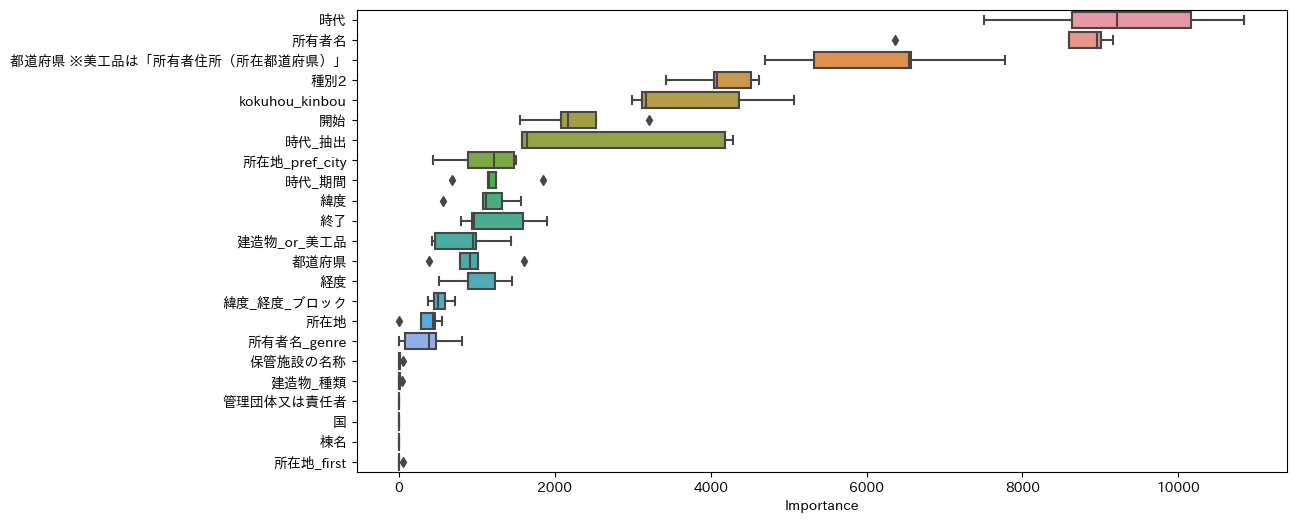

In [118]:
feature_importances = []

for model in models:
    feature_importances.append(model.feature_importance(importance_type="gain"))

feature_importances = np.array(feature_importances)
feature_importance_df = pd.DataFrame(feature_importances, columns=use_col)
sorted_features = feature_importance_df.median().sort_values(ascending=False).index
sorted_feature_importance_df = feature_importance_df[sorted_features]

plt.figure(figsize=(12, 6))
sns.boxplot(data=sorted_feature_importance_df, orient="h")
plt.xlabel("Importance")
plt.show()

In [119]:
from sklearn.metrics import f1_score

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(train["is_kokuhou"], (oof_pred > thr).astype(int))
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr

print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

thr: 0.01, f1_score: 0.16461589624210177
thr: 0.02, f1_score: 0.1959082455052697
thr: 0.03, f1_score: 0.22184133202742407
thr: 0.04, f1_score: 0.24552572706935125
thr: 0.05, f1_score: 0.2631411277476904
thr: 0.060000000000000005, f1_score: 0.2785892411827574
thr: 0.06999999999999999, f1_score: 0.29667721518987344
thr: 0.08, f1_score: 0.3012152777777778
thr: 0.09, f1_score: 0.31088082901554404
thr: 0.09999999999999999, f1_score: 0.3204419889502762
thr: 0.11, f1_score: 0.3249058633674018
thr: 0.12, f1_score: 0.32786885245901637
thr: 0.13, f1_score: 0.33333333333333337
thr: 0.14, f1_score: 0.3400651465798046
thr: 0.15000000000000002, f1_score: 0.3347398030942335
thr: 0.16, f1_score: 0.32963784183296374
thr: 0.17, f1_score: 0.3269082498072475
thr: 0.18000000000000002, f1_score: 0.33115823817292006
thr: 0.19, f1_score: 0.3362218370883882
thr: 0.2, f1_score: 0.33726201269265643
thr: 0.21000000000000002, f1_score: 0.3370998116760829
thr: 0.22, f1_score: 0.3320235756385069
thr: 0.23, f1_score:

In [120]:
test["is_kokuhou"] = (y_pred > best_thr).astype(int)

In [121]:
test[["is_kokuhou"]].to_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv",
    index=False,
)